# Qlearning robot
ML for trading Udacity Course exercise

More info:
https://quantsoftware.gatech.edu/Manual_strategy

A transcription of the Udacity Course lectures can be find on https://docs.google.com/document/d/1ELqlnuTSdc9-MDHOkV0uvSY4RmI1eslyQlU9DgOY_jc/edit?usp=sharing

Kairoart 2018
"""


## Overview

In this project you will implement the Q-Learning and Dyna-Q solutions to the reinforcement learning problem. You will apply them to a navigation problem in this project. In a later project you will apply them to trading. The reason for working with the navigation problem first is that, as you will see, navigation is an easy problem to work with and understand. Note that your Q-Learning code really shouldn't care which problem it is solving. The difference is that you need to wrap the learner in different code that frames the problem for the learner as necessary.

For the navigation problem we have created testqlearner.py that automates testing of your Q-Learner in the navigation problem.

Overall, your tasks for this project include:

    * Code a Q-Learner
    * Code the Dyna-Q feature of Q-Learning
    * Test/debug the Q-Learner in navigation problems

## The navigation task

The navigation task takes place in a 10 x 10 grid world. The particular environment is expressed in a CSV file of integers, where the value in each position is interpreted as follows:

0: blank space.

1: an obstacle.

2: the starting location for the robot.

3: the goal location.

5: quicksand. 

An example navigation problem (world01.csv) is shown below. Following python conventions, [0,0] is upper left, or northwest corner, [9,9] lower right or southeast corner. Rows are north/south, columns are east/west.

3,0,0,0,0,0,0,0,0,0

0,0,0,0,0,0,0,0,0,0

0,0,0,0,0,0,0,0,0,0

0,0,1,1,1,1,1,0,0,0

0,5,1,0,0,0,1,0,0,0

0,5,1,0,0,0,1,0,0,0

0,0,1,0,0,0,1,0,0,0

0,0,0,0,0,0,0,0,0,0

0,0,0,0,0,0,0,0,0,0

0,0,0,0,2,0,0,0,0,0


### Goal

In this example the robot starts at the bottom center, and must navigate to the top left. Note that a wall of obstacles blocks its path, and there is some quicksand along the left side. The objective is for the robot to learn how to navigate from the starting location to the goal with the highest total reward. We define the reward for each step as:

-1 if the robot moves to an empty or blank space, or attempts to move into a wall

-100 if the robot moves to a quicksand space

1 if the robot moves to the goal space

### Assess
Overall, we will assess the performance of a policy as the median reward it incurs to travel from the start to the goal (higher reward is better). We assess a learner in terms of the reward it converges to over a given number of training epochs (trips from start to goal). The problem includes random actions. So, for example, if the learner responds with a "move north" action, there is some probability that the robot will actually move in a different direction. For this reason, the "wise" learner develops policies that keep the robot well away from quicksand. We map this problem to a reinforcement learning problem as follows:

**State:** The state is the location of the robot, it is computed (discretized) as: column location * 10 + row location.

**Actions:** There are 4 possible actions, 0: move north, 1: move east, 2: move south, 3: move west.

**R:** The reward is as described above.

**T:** The transition matrix can be inferred from the CSV map and the actions.


## Import libraries

In [1]:
import pandas as pd
import numpy as np  
import random as rand
import time  
import math  
import QLearner as ql

# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools


## Get values from CVS file

In [3]:
# Get values from cvs file
filename = "testworlds/world01.csv"
df = pd.read_csv(filename, sep=",", header=None)

# Convert dataframe to array
data = df.values

# Make a copy so we can revert to the original map later
originalmap = data.copy() 

## Plot initial map

In [63]:
def plot(array, fig_size=(12, 12)):
    array = np.flipud(array) 
    custom_colorbar = dict(lenmode="fraction",
                        title="Signals",
                        tickmode='array',
                        tickvals= [0,1,2,3,4],  
                        ticktext=["Blank", "Obstacle", "Start", "Goal", "Quicksand"],
                        
                       )
    
    trace = go.Heatmap(z=array,
                          xgap = 1, 
                          ygap = 1,
                          colorbar=custom_colorbar
                             
                      )
    
    data = [trace]
    
    axis_template = dict(autorange = True,
             showgrid = True, zeroline = True,
             linecolor = 'white', showticklabels = True,
             ticks = '' )
    layout = dict(
        title = 'Robot Map',
        xaxis = axis_template,
        yaxis = axis_template,
        
        
    )

    fig = dict(data=data, layout=layout)
    
    
    fig['layout'].update(height=600)
    iplot(fig)

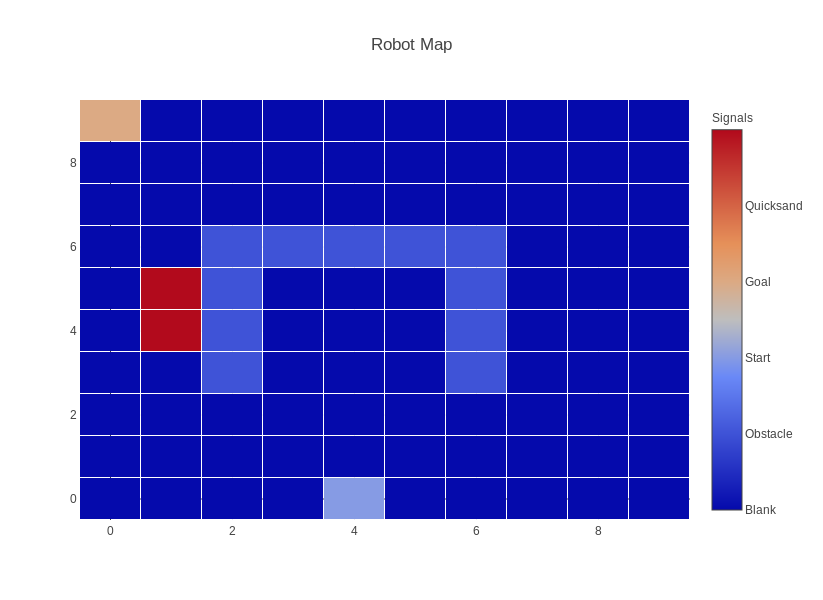

In [64]:
plot(data)

In [ ]:
# print out the map  
def printmap(data):  
    plot(data)

    for row in range(0, data.shape[0]):  
        for col in range(0, data.shape[1]):  
            print(data[row, col])
            if data[row,col] == str(0): # Empty space  
                data[row,col] = " ",  
            if data[row,col] == str(1): # Obstacle  
                data[row,col] = "O",  
            if data[row,col] == str(2): # El roboto  
                data[row,col] = "*",   
            if data[row,col] == str(3): # Goal  
                data[row,col] = "X",   
            if data[row,col] == str(4): # Trail  
                data[row,col] = ".",   
            if data[row,col] == str(5): # Quick sand  
                data[row,col] = "-", 
            if data[row,col] == str(6): # Stepped in quicksand  
                data[row,col] = " @",   


# find where the robot is in the map  
def getrobotpos(data):  
    R = -999  
    C = -999  
    for row in range(0, data.shape[0]):  
        for col in range(0, data.shape[1]):  
            if data[row,col] == 2:  
                C = col  
                R = row  
    if (R+C)<0:  
        print("warning: start location not defined")
    return R, C  
 
# find where the goal is in the map 
def getgoalpos(data):  
    R = -999  
    C = -999  
    for row in range(0, data.shape[0]):  
        for col in range(0, data.shape[1]):  
            if data[row,col] == 3: 
                C = col  
                R = row  
    if (R+C)<0:  
        print("warning: goal location not defined")
    return (R, C)  

# move the robot and report reward 
def movebot(data,oldpos,a):  
    testr, testc = oldpos  

    randomrate = 0.20 # how often do we move randomly  
    quicksandreward = -100 # penalty for stepping on quicksand  

    # decide if we're going to ignore the action and  
    # choose a random one instead  
    if rand.uniform(0.0, 1.0) <= randomrate: # going rogue  
        a = rand.randint(0,3) # choose the random direction  

    # update the test location 
    if a == 0: #north  
        testr = testr - 1  
    elif a == 1: #east  
        testc = testc + 1 
    elif a == 2: #south  
        testr = testr + 1
    elif a == 3: #west  
        testc = testc - 1

    reward = -1 # default reward is negative one 
    # see if it is legal. if not, revert 
    if testr < 0: # off the map 
        testr, testc = oldpos 
    elif testr >= data.shape[0]: # off the map 
        testr, testc = oldpos 
    elif testc < 0: # off the map 
        testr, testc = oldpos  
    elif testc >= data.shape[1]: # off the map 
        testr, testc = oldpos  
    elif data[testr, testc] == 1: # it is an obstacle 
        testr, testc = oldpos  
    elif data[testr, testc] == 5: # it is quicksand  
        reward = quicksandreward  
        data[testr, testc] = 6 # mark the event 
    elif data[testr, testc] == 6: # it is still quicksand  
        reward = quicksandreward 
        data[testr, testc] = 6 # mark the event 
    elif data[testr, testc] == 3:  # it is the goal  
        reward = 1 # for reaching the goal 
 
    return (testr, testc), reward #return the new, legal location 
  
# convert the location to a single integer 
def discretize(pos):  
    return pos[0]*10 + pos[1]  

def test(map, epochs, learner, verbose):  
    
    # each epoch involves one trip to the goal 
    startpos = getrobotpos(map) #find where the robot starts  
    goalpos = getgoalpos(map) #find where the goal is 
    scores = np.zeros((epochs,1))  
    for epoch in range(1,epochs+1): 
        total_reward = 0 
        data = map.copy() 
        robopos = startpos 
        state = discretize(robopos) #convert the location to a state 
        action = learner.query_set_state(state) #set the state and get first action  
        count = 0  
        while (robopos != goalpos) & (count<10000): 

            #move to new location according to action and then get a new action 
            newpos, stepreward = movebot(data,robopos,action)  
            if newpos == goalpos:  
                r = 1 # reward for reaching the goal 
            else:  
                r = stepreward # negative reward for not being at the goal 
            state = discretize(newpos)  
            
            action = learner.query(state, r) 

            if data[robopos] != 6: 
                data[robopos] = 4 # mark where we've been for map printing 
            if data[newpos] != 6: 
                data[newpos] = 2 # move to new location 
            robopos = newpos # update the location  
            #if verbose: time.sleep(1) 
            total_reward += stepreward  
            count = count + 1  
        if count == 100000: 
            print("timeout")
        if verbose: printmap(data)  
        if verbose: 
            print(epoch, total_reward)
        scores[epoch-1,0] = total_reward  
    return np.median(scores)  

## Test

In [ ]:
def test_code(data): 

    
    # Print lots of debug stuff if True
    verbose = True  
    
    rand.seed(5)  
    

        
    ######## run non-dyna test ######## 
    learner = ql.QLearner(num_states=100,\
        num_actions = 4, \
        alpha = 0.2, \
        gamma = 0.9, \
        rar = 0.98, \
        radr = 0.999, \
        dyna = 0, \
        verbose=False) #initialize the learner  
    epochs = 500 

    total_reward = test(data, epochs, learner, verbose) 
    print("Non-dyna test")
    print ("Epochs: ", epochs, "\nMedian total_reward" , total_reward) 
    print("")
    non_dyna_score = total_reward  

    ######## run dyna test ########  
    learner = ql.QLearner(num_states=100,\
        num_actions = 4, \
        alpha = 0.2, \
        gamma = 0.9, \
        rar = 0.5, \
        radr = 0.99, \
        dyna = 200, \
        verbose=False) #initialize the learner 
    epochs = 50  
    data = originalmap.copy()  
    total_reward = test(data, epochs, learner, verbose) 
    print("Dyna test")
    print("Epochs: ", epochs, "\nMedian total_reward: " , total_reward)
    print("")
    dyna_score = total_reward  
    
    if verbose:        
        plot(data)
    print ("Results for", filename  )
    print ("Non_dyna score: ", non_dyna_score)
    print ("Dyna score    :", dyna_score) 

In [ ]:
test_code(data)
